In [77]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
from nltk.corpus import stopwords
import string
from wordcloud import WordCloud
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer

from nltk.tokenize import WhitespaceTokenizer

import plotly.graph_objects as go
import plotly.express as px
import os

warnings.filterwarnings('ignore')

In [102]:
data = pd.read_csv('UpdatedResumeDataSet.csv', encoding="utf-8")
print(data.shape)
data.describe()

(962, 2)


,Category,Resume
count,962,962
unique,25,166
top,Java Developer,"Technical Skills Web Technologies: Angular JS,..."
freq,84,18


In [103]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 962 entries, 0 to 961
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Category  962 non-null    object
 1   Resume    962 non-null    object
dtypes: object(2)
memory usage: 15.2+ KB


In [104]:

#Revisar nulos
data[data.isna().any(axis=1) | data.isnull().any(axis=1)]

,Category,Resume


In [105]:
data.nunique()

Category     25
Resume      166
dtype: int64

In [107]:
valores_unicos = data.Category.unique()
valores_unicos

array(['Data Science', 'HR', 'Advocate', 'Arts', 'Web Designing',
       'Mechanical Engineer', 'Sales', 'Health and fitness',
       'Civil Engineer', 'Java Developer', 'Business Analyst',
       'SAP Developer', 'Automation Testing', 'Electrical Engineering',
       'Operations Manager', 'Python Developer', 'DevOps Engineer',
       'Network Security Engineer', 'PMO', 'Database', 'Hadoop',
       'ETL Developer', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [117]:
'''valores_a_eliminar = [
    'Automation Testing ',
    'Designer ',
    'ETL Developer ',
    'Information Technology ',
    'Project manager ',
    'SAP Developer ',
    'Security Analyst ',
    'Web Developer '
]'''

valores_a_eliminar = [
    'HR',
    'Advocate',
    'Arts',
    'Business Analyst',
    'SAP Developer',
    'Automation Testing',
    'Electrical Engineering',
    'Operations Manager',
    'PMO',
    'Hadoop',
    'ETL Developer',
    'Mechanical Engineer',
    'Sales',
    'Health and fitness',
    'Civil Engineer',
    'ETL Developer'
]

df = data[~data['Category'].isin(valores_a_eliminar)]

In [118]:
#imprimimos las etiquetas nuevas que quedaron
df['Category'] = df['Category'].str.rstrip()

valores_unicos = df.Category.unique()
valores_unicos

array(['Data Science', 'Web Designing', 'Java Developer',
       'Python Developer', 'DevOps Engineer', 'Network Security Engineer',
       'Database', 'DotNet Developer', 'Blockchain', 'Testing'],
      dtype=object)

In [119]:
df.nunique()

Category    10
Resume      75
dtype: int64

In [121]:
df['Category'].value_counts()

Category
Java Developer               84
Testing                      70
DevOps Engineer              55
Python Developer             48
Web Designing                45
Data Science                 40
Blockchain                   40
Database                     33
DotNet Developer             28
Network Security Engineer    25
Name: count, dtype: int64

In [87]:
# Reemplaza 'instruccion' con el nombre de tu columna
# Reemplaza 'etiqueta' con la etiqueta que quieres contar
#conteo_etiquetas = df['instruction'].value_counts().get('Generate a Resume for a DotNet Developer Job', 0)

#print(f"La etiqueta aparece {conteo_etiquetas} veces")

In [88]:
#df['instruction'] = df['instruction'].str.replace('Generate a Resume for a ', '')
#df['instruction'] = df['instruction'].str.split('Job').str[0]

#df.reset_index(drop=True, inplace=True)

#df['instruction']

In [122]:
def cleanResume(resumeText):
    resumeText = re.sub('http\S+\s*', ' ', resumeText)  # remove URLs
    resumeText = re.sub('RT|cc', ' ', resumeText)  # remove RT and cc
    resumeText = re.sub('#\S+', '', resumeText)  # remove hashtags
    resumeText = re.sub('@\S+', '  ', resumeText)  # remove mentions
    resumeText = re.sub('[%s]' % re.escape("""!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~"""), ' ', resumeText)  # remove punctuations
    resumeText = re.sub(r'[^\x00-\x7f]',r' ', resumeText) # remove non-ascii characters
    resumeText = re.sub('\s+', ' ', resumeText)  # remove extra whitespace
    resumeText = resumeText.lower()

    # Eliminar stopwords
    #stopwords = set(stopwords.words('english'))
    #words = resumeText.split()
    #filtered_words = [word for word in words if word not in stop_words]
    #resumeText = " ".join(filtered_words)
    # Lematizar las palabras utilizando spaCy (pasar a forma base las palabras)
    #doc = nlp(resumeText)
    #resumeText = " ".join(token.lemma for token in doc)
    # Eliminar etiquetas HTML utilizando BeautifulSoup
    #bfs = BeautifulSoup(resumeText, "html.parser")
    #resumeText = bfs.get_text()
    # Eliminar espacios en blanco adicionales
    #resumeText = resumeText.strip()

    return resumeText

def clean_ussles_words(resumen, categoria):
    # Convertimos la categoría a minúsculas para asegurar la correspondencia con las claves del diccionario
    palabras_irrelevantes = diccionarios.get(categoria, set())
    palabras_limpias = [palabra for palabra in resumen.split() if palabra not in palabras_irrelevantes]
    return ' '.join(palabras_limpias)


# Función para encontrar las habilidades comunes
def find_common_skills(category):
    skills = []
    for key, value in skills_dict.items():
        if key == category:
            skills = value.split(', ')
            break
    return skills



In [123]:
df['Clean_Resume'] = df["Resume"].map(cleanResume)

df['Clean_Resume'] = df['Clean_Resume'].str.replace('Â', '')
df['Clean_Resume'] = df['Clean_Resume'].str.replace('â', '')

In [124]:
# Ruta a la carpeta que contiene tus archivos de diccionarios
carpeta_diccionarios = 'diccionarios'

# Cargar los diccionarios de palabras irrelevantes desde los archivos
diccionarios = {}


for archivo in os.listdir(carpeta_diccionarios):
    categoria = archivo.split('.')[0]  # Asume que el nombre del archivo es exactamente la categoría
    with open(os.path.join(carpeta_diccionarios, archivo), 'r', encoding='utf-8') as f:
        # Crea un conjunto de palabras irrelevantes para cada categoría
         # Elimina las comas de cada palabra antes de agregarlas al conjunto
         diccionarios[categoria] = set(palabra.strip().rstrip(',') for palabra in f.read().splitlines())
         


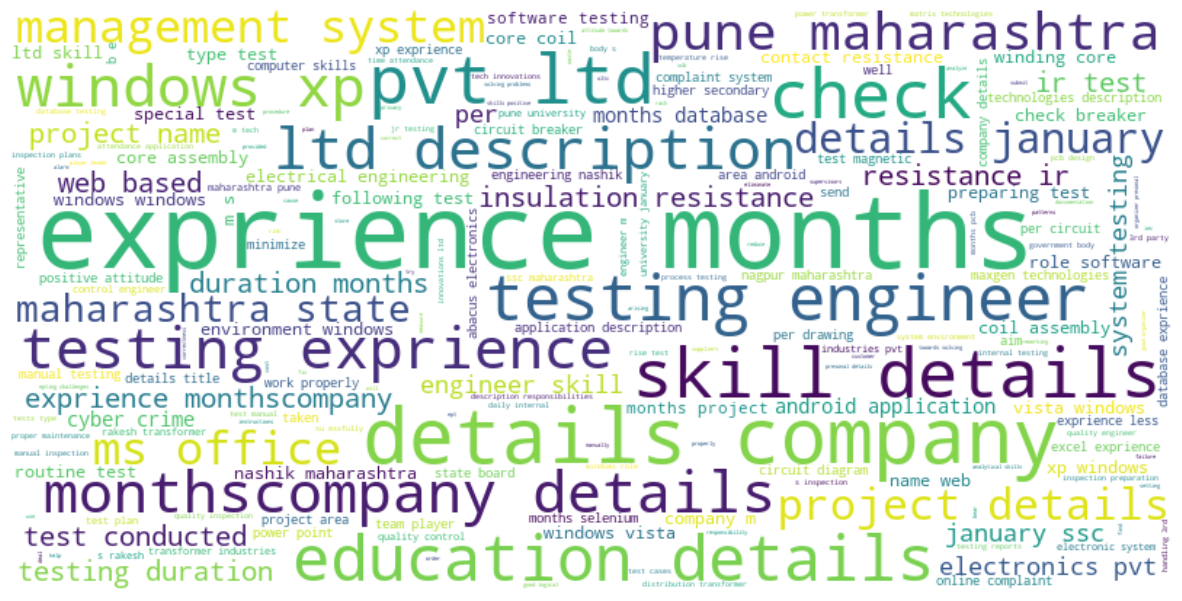

In [126]:
# Filtrar los resúmenes por la etiqueta 'X'
all_resumes = df[df['Category'] == 'Testing']['Clean_Resume']

# Combinar todos los resúmenes en una única cadena de texto
combined_resumes = ' '.join(all_resumes)

# Crear y visualizar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_resumes)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes para una visualización más limpia
plt.show()

In [127]:

# Aplicar la función de limpieza a cada fila del DataFrame
df['Clean_Resume'] = df.apply(lambda fila: clean_ussles_words(fila['Clean_Resume'], fila['Category']), axis=1)# revisar si se aplicaron lso diccionarios

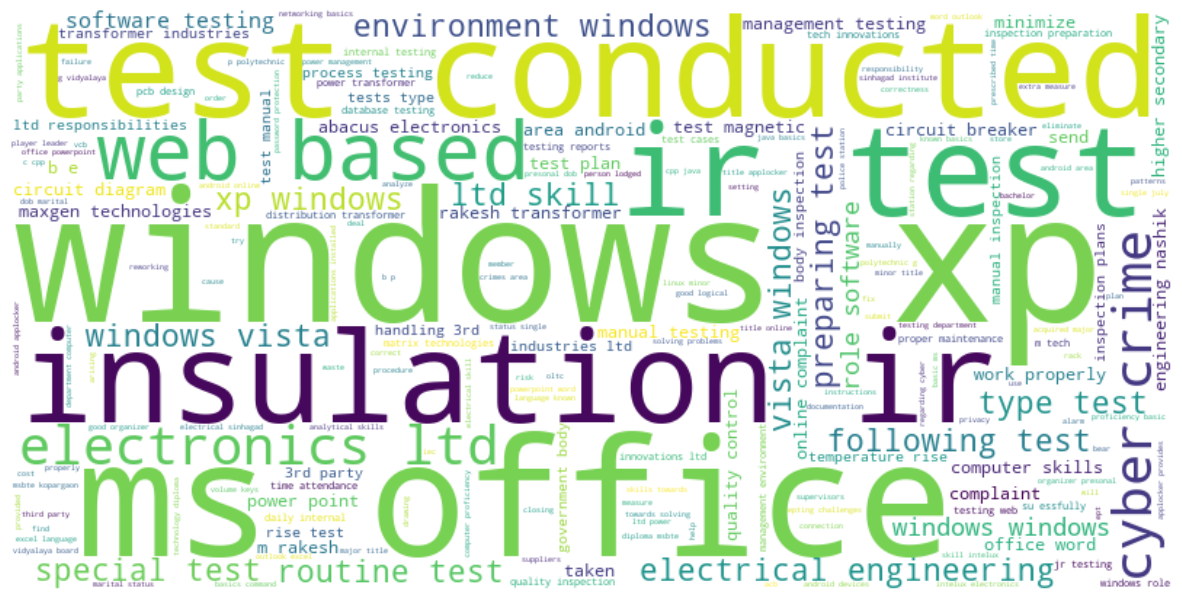

In [128]:
# Filtrar los resúmenes por la etiqueta 'X'
all_resumes = df[df['Category'] == 'Testing']['Clean_Resume']

# Combinar todos los resúmenes en una única cadena de texto
combined_resumes = ' '.join(all_resumes)

# Crear y visualizar la nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(combined_resumes)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # No mostrar los ejes para una visualización más limpia
plt.show()

In [129]:
skills_dict = {
    'Blockchain': 'Ethereum Smart Contracts, Cryptography, Solidity, DApp Development, Hyperledger Fabric, Consensus Algorithms, Node.js, Corda, Blockchain System Design, Truffle, Ganache, Blockchain API, Ripple, Litecoin, Bitcoin, Blockchain Security, Key Management, DeFi, NFTs',
    'Data Science': 'Python, R, Machine Learning, Deep Learning, Statistical Analysis, pandas, NumPy, Data Visualization, Matplotlib, Seaborn, SQL, NoSQL, Spark, Hadoop, PySpark, Ensemble Models, PCA, t-SNE, Airflow, Keras, TensorFlow, Time Series, Predictive Analysis, A/B Testing',
    'Database': 'SQL, PL/SQL, Database Administration, MySQL, PostgreSQL, Oracle, MongoDB, Cassandra, Database Design, Normalization, Data Recovery, Query Optimization, Distributed Databases, Database Tuning, Replication, Sharding, Cluster Management, ETL, Data Warehousing, Real-time DB, Redis, Database Security, Compliance',
    'DevOps Engineer': 'CI/CD, Jenkins, GitLab CI, Docker, Kubernetes, Ansible, Terraform, Monitoring, Logging, Prometheus, Grafana, ELK, Unix Administration, Bash, Python, CloudFormation, Spinnaker, Secrets Management, Ruby, Perl, Vagrant',
    'DotNet Developer': 'C#, .NET Framework, ASP.NET MVC, Entity Framework, LINQ, Azure, WPF, Windows Forms, RESTful APIs, .NET Core, Microservices, SignalR, RabbitMQ, CI/CD, TeamCity, Xamarin, Stress Testing',
    'Java Developer': 'Java, Spring Framework, Spring Boot, Hibernate, JPA, Maven, Gradle, SOAP, REST, JUnit, Design Patterns, Jersey, Netflix OSS, Spring Security, Android Development, SQL, NoSQL Integration, JVM Optimization',
    'Network Security Engineer': 'Firewalls, VPNs, IDS/IPS, SSL/TLS, SSH, Vulnerability Assessment, Pentesting, Intrusion Detection, ISO 27001, NIST, Cryptography, SIEMs, Digital Forensics, Firewall Configuration, Network Security Policies, DLP, CISSP, CISM',
    'Python Developer': 'Python, Django, Flask, Scripting, Data Analysis, Pandas, NumPy, Web Scraping, BeautifulSoup, Scrapy, API Development, FastAPI, Django REST, pytest, unittest, Pyramid, Bottle, asyncio, ORM, SQLAlchemy, Packaging, Kafka, RabbitMQ',
    'Testing': 'HTML, CSS, JavaScript, UX, UI, Frameworks, Graphic Design, Photoshop, Illustrator, Logo Design, Prototyping, Accessibility, SEO, Management, Test Animation, Optimization, Security, Responsive Design',
    'Web Designing': 'HTML, CSS, JavaScript, Responsive Design, UX, UI, Bootstrap, Foundation, Graphic Design, Photoshop, Illustrator, Logo Design, Prototyping, Accessibility, SEO, WordPress, Git, Web Animation, Debugging, Performance Optimization, Web Security'
}


In [131]:
# Agregar la columna de habilidades comunes
df['Common Skills'] = df['Category'].apply(find_common_skills)

#hacer todo minusculas
df["Common Skills"] = [
    [palabra.lower() for palabra in lista] for lista in df["Common Skills"]
]

In [132]:
df["Common Skills"] = df["Common Skills"].str.join(" ")

print(df["Common Skills"])

0      python r machine learning deep learning statis...
1      python r machine learning deep learning statis...
2      python r machine learning deep learning statis...
3      python r machine learning deep learning statis...
4      python r machine learning deep learning statis...
                             ...                        
957    html css javascript ux ui frameworks graphic d...
958    html css javascript ux ui frameworks graphic d...
959    html css javascript ux ui frameworks graphic d...
960    html css javascript ux ui frameworks graphic d...
961    html css javascript ux ui frameworks graphic d...
Name: Common Skills, Length: 468, dtype: object


In [98]:
#eliminar valores
#valores_a_eliminar = ["Java Developer","Python Developer"]
#resumeDataSet = df[~df['Category'].isin(valores_a_eliminar)]

In [100]:
df.to_csv("Datase_ML3.csv", index=False)